In [1]:
import xarray as xr
import numpy as np
import xesmf as xe
import metpy
import pandas as pd
import os
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
plate = ccrs.PlateCarree()

In [3]:
def get_regridder(ds_from, ds_to, var_type, i, j):
    lon = ds.goes_imager_projection.longitude_of_projection_origin
    xsz = ds.x.size
    ysz = ds.y.size
    
    regrid_name = f'data/regridders/regird_{var_type}_{lon}_{i}-{xsz}_{j}-{ysz}.nc'
    
    if os.path.exists(regrid_name):
        regridder = xe.Regridder(ds_from, ds_to, "bilinear", unmapped_to_nan=True, weights=regrid_name)
    else:
        regridder = xe.Regridder(ds_from, ds_to, "bilinear", unmapped_to_nan=True)
        regridder.to_netcdf(regrid_name)
    
    return regridder
        
def add_met_blh(ds, met, blh):
    dx = 500
    dy = 500

    time = pd.to_datetime(ds.time.item()).normalize()
    times_da = xr.DataArray([time], [('time', [time])])
    ds['time'] = times_da

    for d in [met, blh]:
        for var in d.data_vars:
            ds[var] = xr.full_like(ds.AOD, fill_value=np.nan)
            ds[var].attrs = d[var].attrs

    metds = met.sel(time=time.strftime('%m/%d/%Y'))
    blhds = blh.sel(time=time.strftime('%m/%d/%Y'))

    pbar = tqdm(range(int(np.ceil(ds.x.size / dx))))
    for i in pbar:
        for j in range(int(np.ceil(ds.y.size / dy))):
            pbar.set_description(f'{i}-{j}')
            sub = ds.isel(x=slice(i * dx, (i+1)*dx), y=slice(j * dy, (j+1)*dy))

            for vartype, ads in zip(['met', 'blh'], [metds, blhds]):
                regridder = get_regridder(ads, ds, vartype, i, j)
                out = regridder(ads)
                out = out.expand_dims(time=times_da)
                for var in ads.data_vars:
                    ds[var].loc[dict(x=out.x, y=out.y)] = out[var]
    return ds

def add_pm(ds, df, proj):
    time = pd.to_datetime(ds.time.item())
    sub = df.loc[time.strftime('%Y-%m-%d')]

    transformed = proj.transform_points(src_crs=ccrs.PlateCarree(), x=sub['longitude'], y=sub['latitude'])
    sub['proj_longitude'] = transformed[:,0]
    sub['proj_latitude'] = transformed[:,1]

    ds['PM25'] = xr.full_like(ds.AOD, fill_value=np.nan).astype(np.float32)
    ds['PM25'].attrs = {}

    for idx, row in sub.iterrows():
        if (row.proj_longitude > ds.x.min().item()) \
            and (row.proj_longitude < ds.x.max().item()) \
            and (row.proj_latitude > ds.y.min().item()) \
            and (row.proj_latitude < ds.y.max().item()):

            data = ds.sel(
                x=row.proj_longitude, 
                y=row.proj_latitude, 
                method='nearest', 
                tolerance=2000
            )
            ds['PM25'].loc[dict(x=data.x, y=data.y)] = row.value
    return ds

In [4]:
def day_number_to_date(year, day_number):
    date = pd.to_datetime(year, format='%Y')
    
    return date + pd.to_timedelta(day_number - 1, unit='D') 

In [5]:
df = pd.concat(
    [pd.read_csv(f'/Volumes/Minuet/research/EPA/daily_88101_{year}.csv', parse_dates=['Date Local']) 
     for year in range(2017, 2023)],
    axis=0
)

df.rename(columns = {
    'Date Local':'time', 
    'Arithmetic Mean': 'value',
    'Latitude': 'latitude',
    'Longitude': 'longitude'
}, inplace = True)

keep = ['latitude', 'longitude', 'time', 'value','Local Site Name', 'Address', 'State Name', 'County Name','City Name', 'POC']
df.drop(columns=df.columns.difference(keep),inplace=True)
df = df.loc[df.value >= 0]
df = df.groupby(['time', 'longitude', 'latitude']).mean().reset_index().set_index('time')
df.sort_index(inplace=True)

/var/folders/j8/13gdnhs51_g_jl1wlxj7h3tm0000gn/T/ipykernel_25299/4166414355.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['time', 'longitude', 'latitude']).mean().reset_index().set_index('time')


In [6]:
dates = pd.date_range('05/24/2017', day_number_to_date(2022, 288), freq='1d')
met = None
blh = None

In [7]:
dates = pd.date_range('01/01/2021', '12/31/2021', freq='1d')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

path='/Volumes/Canon/matched'

pbar = tqdm(dates)
for date in pbar:
    pbar.set_description(f'{date.year} {date.day_of_year}')
    
    day = f'{date.day_of_year:03}'
    
    save_path = os.path.join(path, f'{date.year}')
    os.makedirs(save_path, exist_ok=True)
    csv_path = os.path.join(save_path, f'{day}.csv')
    save_path = os.path.join(save_path, f'{day}.nc')
    if os.path.exists(save_path):
        continue

    fname = f'/Volumes/Canon/averages/daily/{date.year}/{date.day_of_year:03}.nc'
    try:
        with xr.open_dataset(fname) as ds:
            ds.load()
        xs, ys = np.meshgrid(ds.x, ds.y)
        proj = ds.metpy.parse_cf('AOD').metpy.cartopy_crs
        transformed = plate.transform_points(src_crs=proj, x=xs, y=ys)

        ds = ds.assign_coords({
                "lat":(["y","x"],transformed[:,:,1]),
                "lon":(["y","x"],transformed[:,:,0])
            })
        ds.lat.attrs["units"] = "degrees_north"
        ds.lon.attrs["units"] = "degrees_east"
    except FileNotFoundError:
        continue
        
    time = pd.to_datetime(ds.time.item()).normalize()
    
    if (met is None) or not (time in met.time):
        with xr.open_dataset(f'/Volumes/Minuet/research/ERA5/era5_land/era5_land_{time.year}{time.month:02}.nc') as met:
            met.load()
        met = met.resample(time='1d').mean()
        met = met.rename({"longitude": "lon", "latitude": "lat"})

    if (blh is None) or not (time in blh.time):
        with xr.open_dataset(f'/Volumes/Minuet/research/ERA5/era5_pblh_{time.year}.nc') as blh:
            blh.load()
        blh = blh.resample(time='1d').mean()
        blh = blh.rename({"longitude": "lon", "latitude": "lat"})

    ds = add_met_blh(ds, met, blh)
    ds = add_pm(ds, df, proj)
    csv = ds.drop_vars('goes_imager_projection').to_dataframe().reset_index().drop(columns=['x', 'y'])
    csv.dropna(subset=['PM25', 'AOD']).to_csv(csv_path, index=False)
    ds.to_netcdf(save_path)

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

# Plots

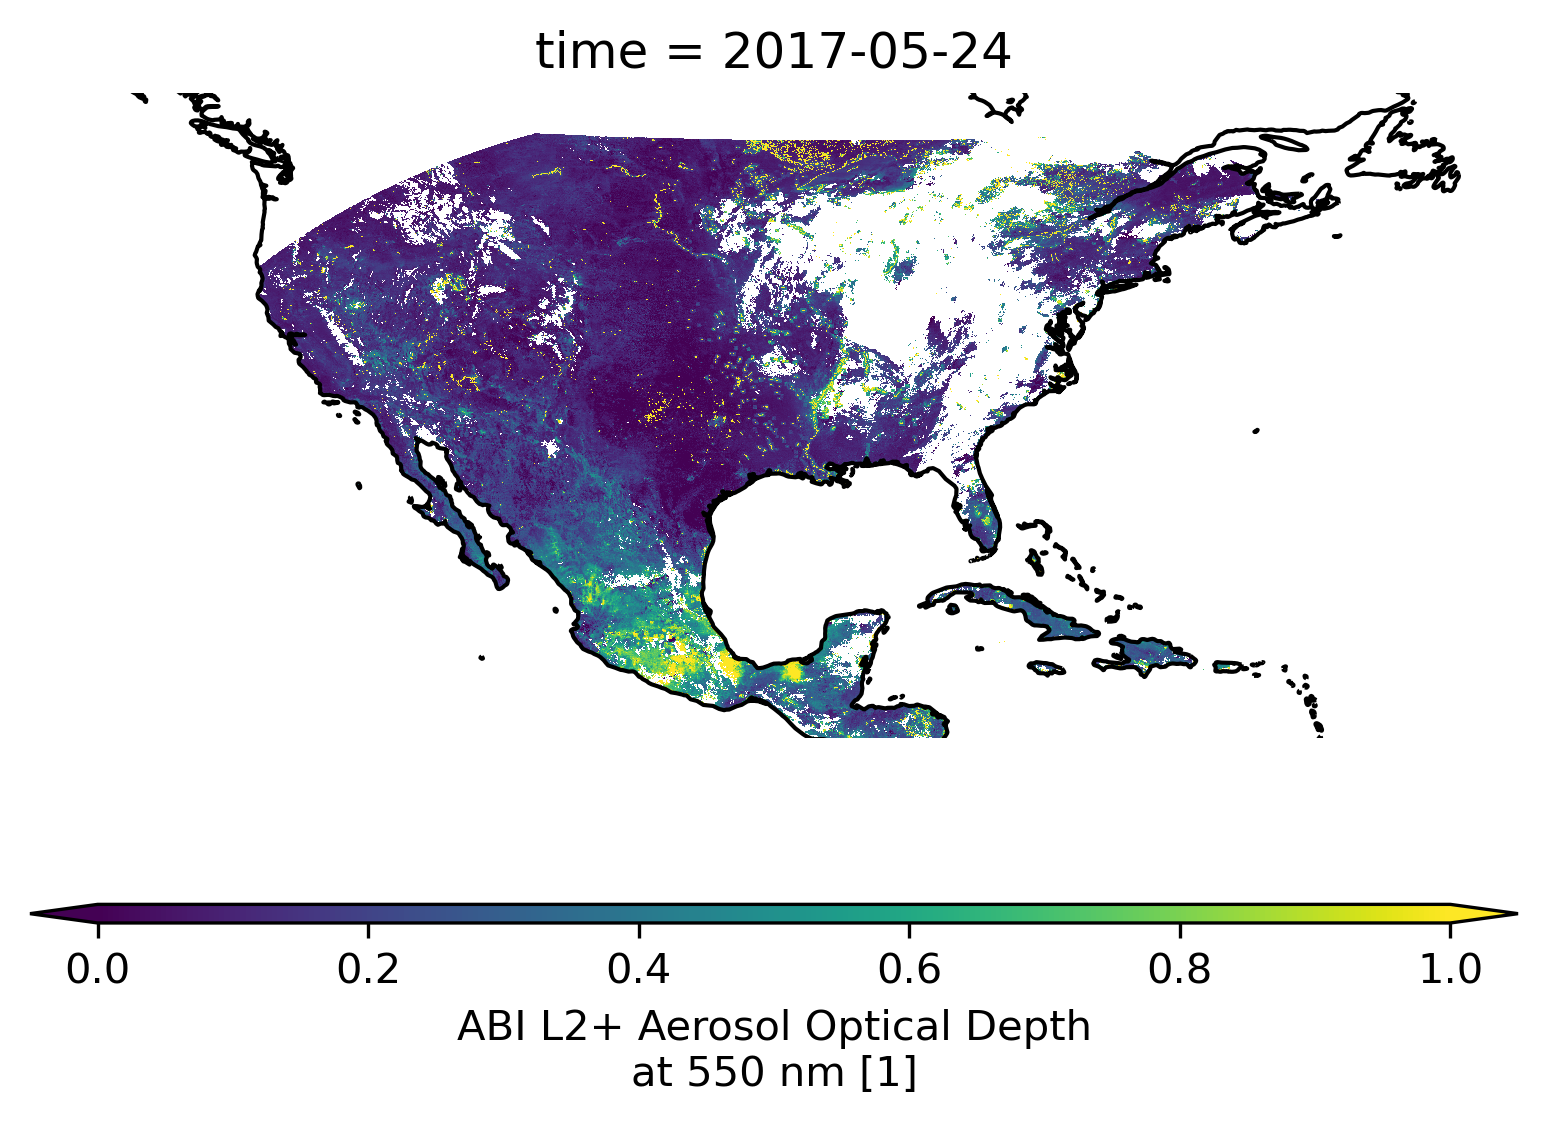

In [24]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=-75)), dpi=300)

ds.AOD.plot(ax=ax, transform=proj, vmin=0, vmax=1, add_colorbar=True, cmap='viridis', cbar_kwargs=dict(orientation='horizontal', aspect=80))

ax.coastlines()
ax.spines[:].set_visible(False)

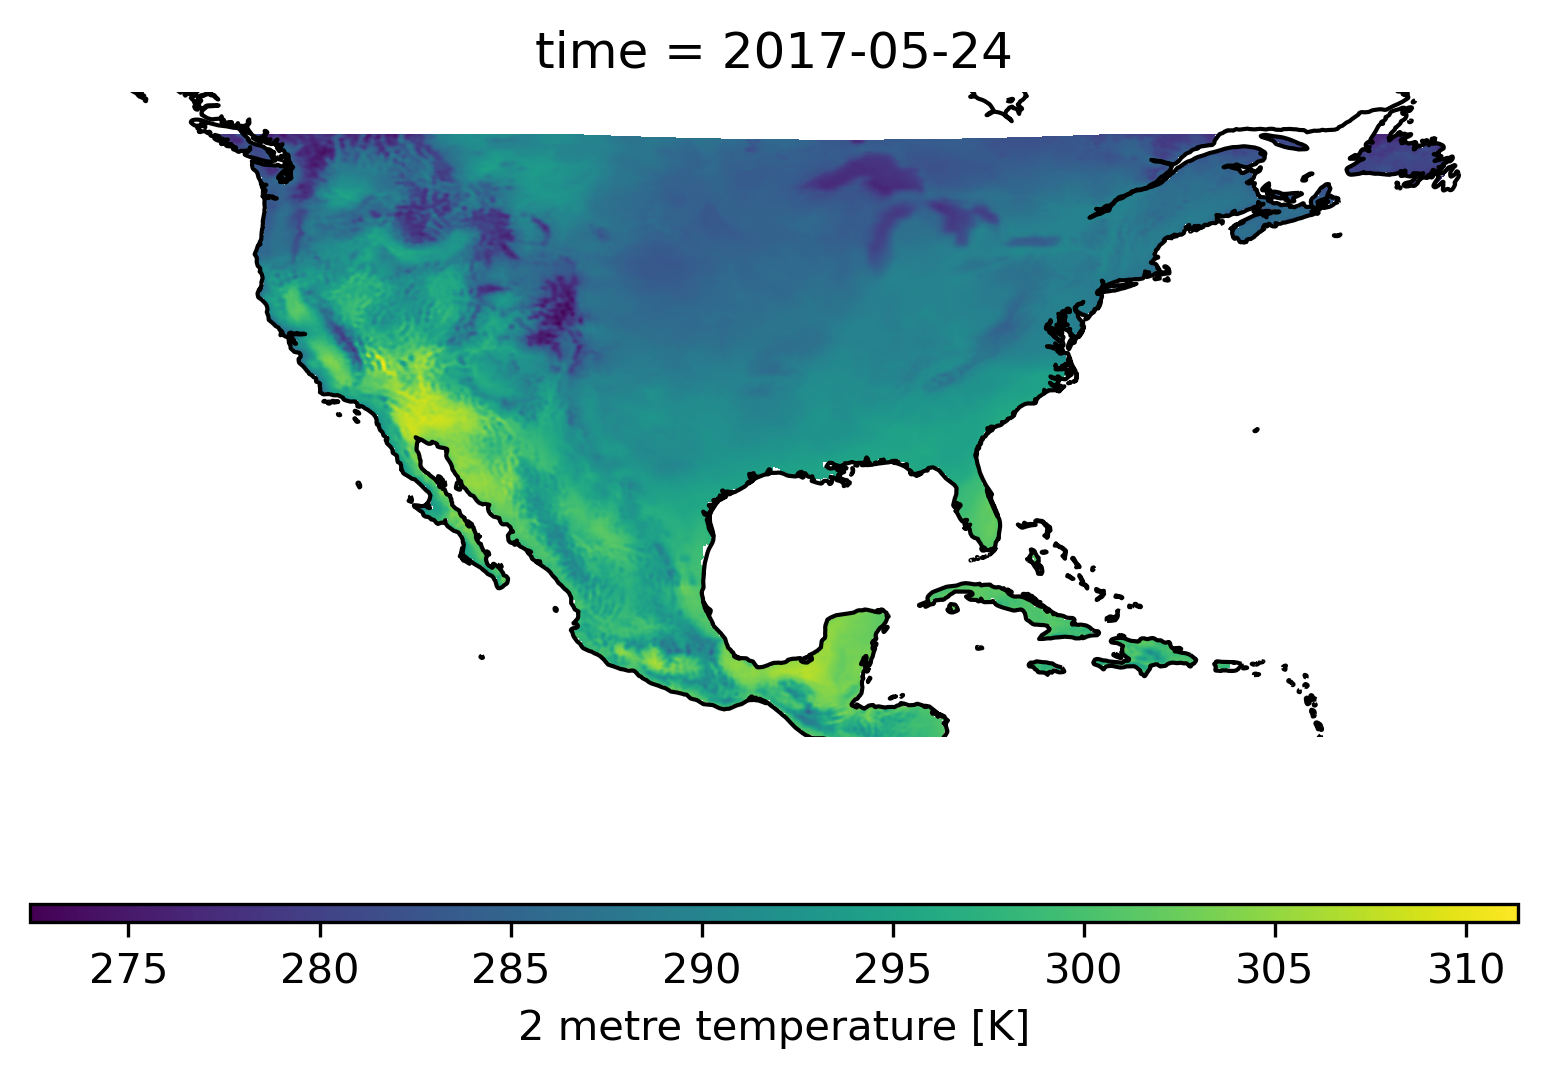

In [25]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=-75)), dpi=300)

ds.t2m.plot(ax=ax, transform=proj, add_colorbar=True, cmap='viridis', cbar_kwargs=dict(orientation='horizontal', aspect=80))

ax.coastlines()
ax.spines[:].set_visible(False)

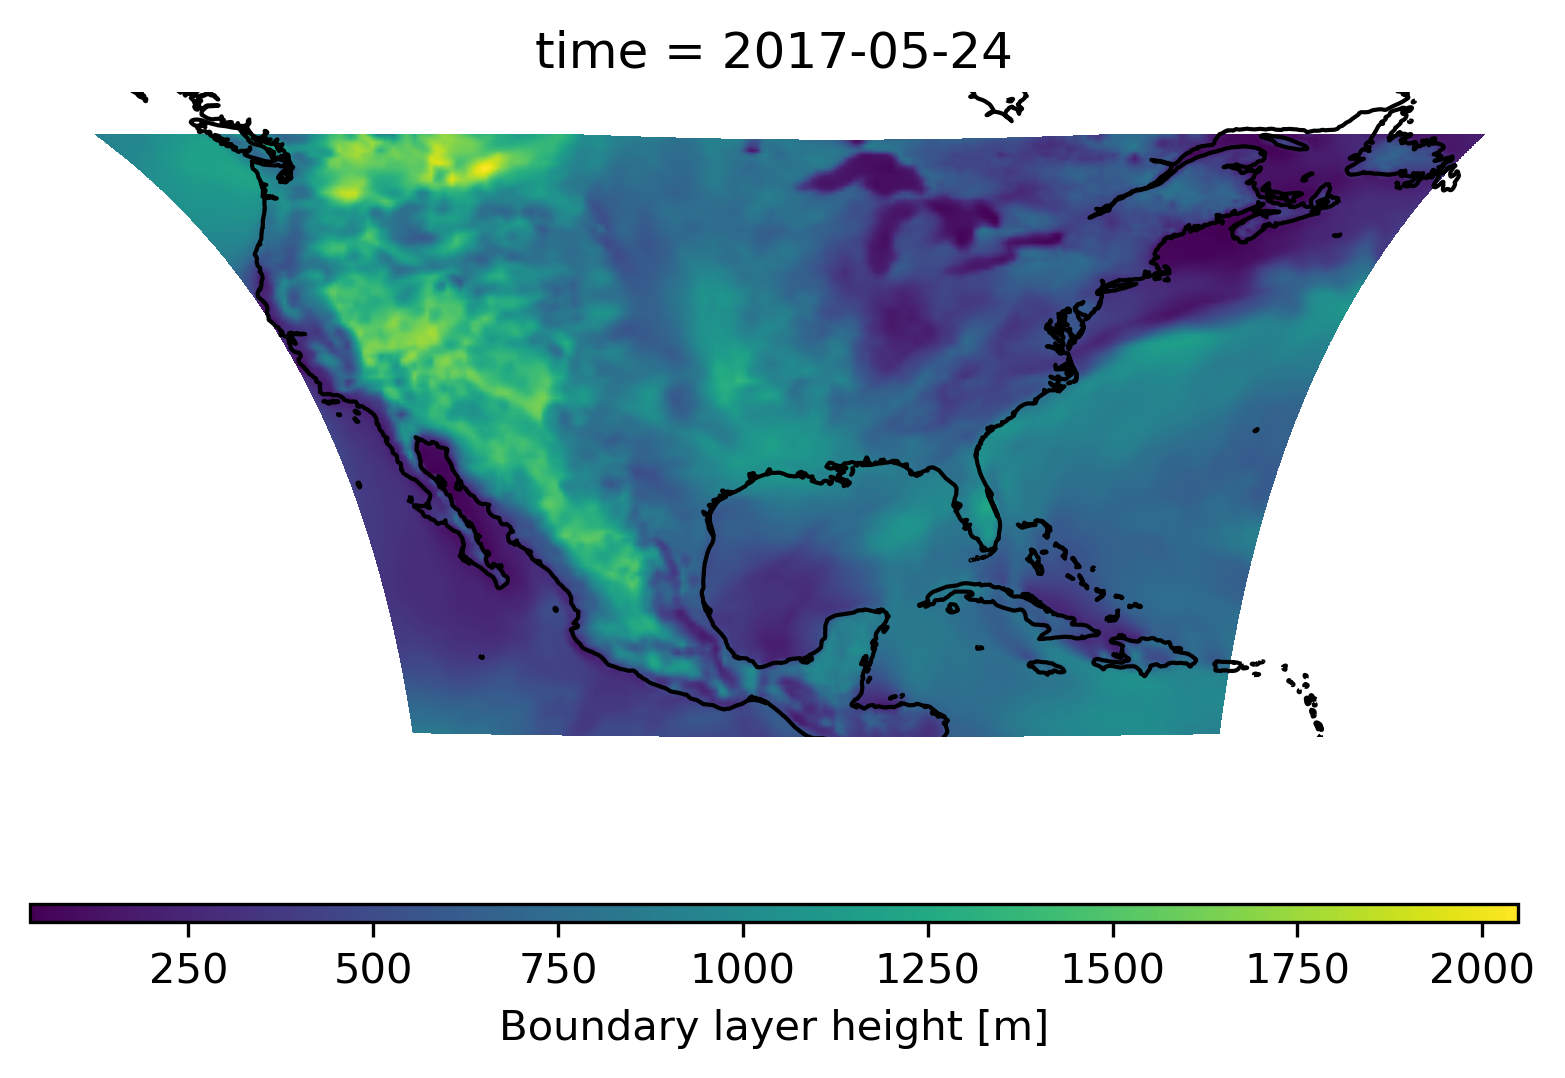

In [26]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=-75)), dpi=300)

ds.blh.plot(ax=ax, transform=proj, add_colorbar=True, cmap='viridis', cbar_kwargs=dict(orientation='horizontal', aspect=80))

ax.coastlines()
ax.spines[:].set_visible(False)

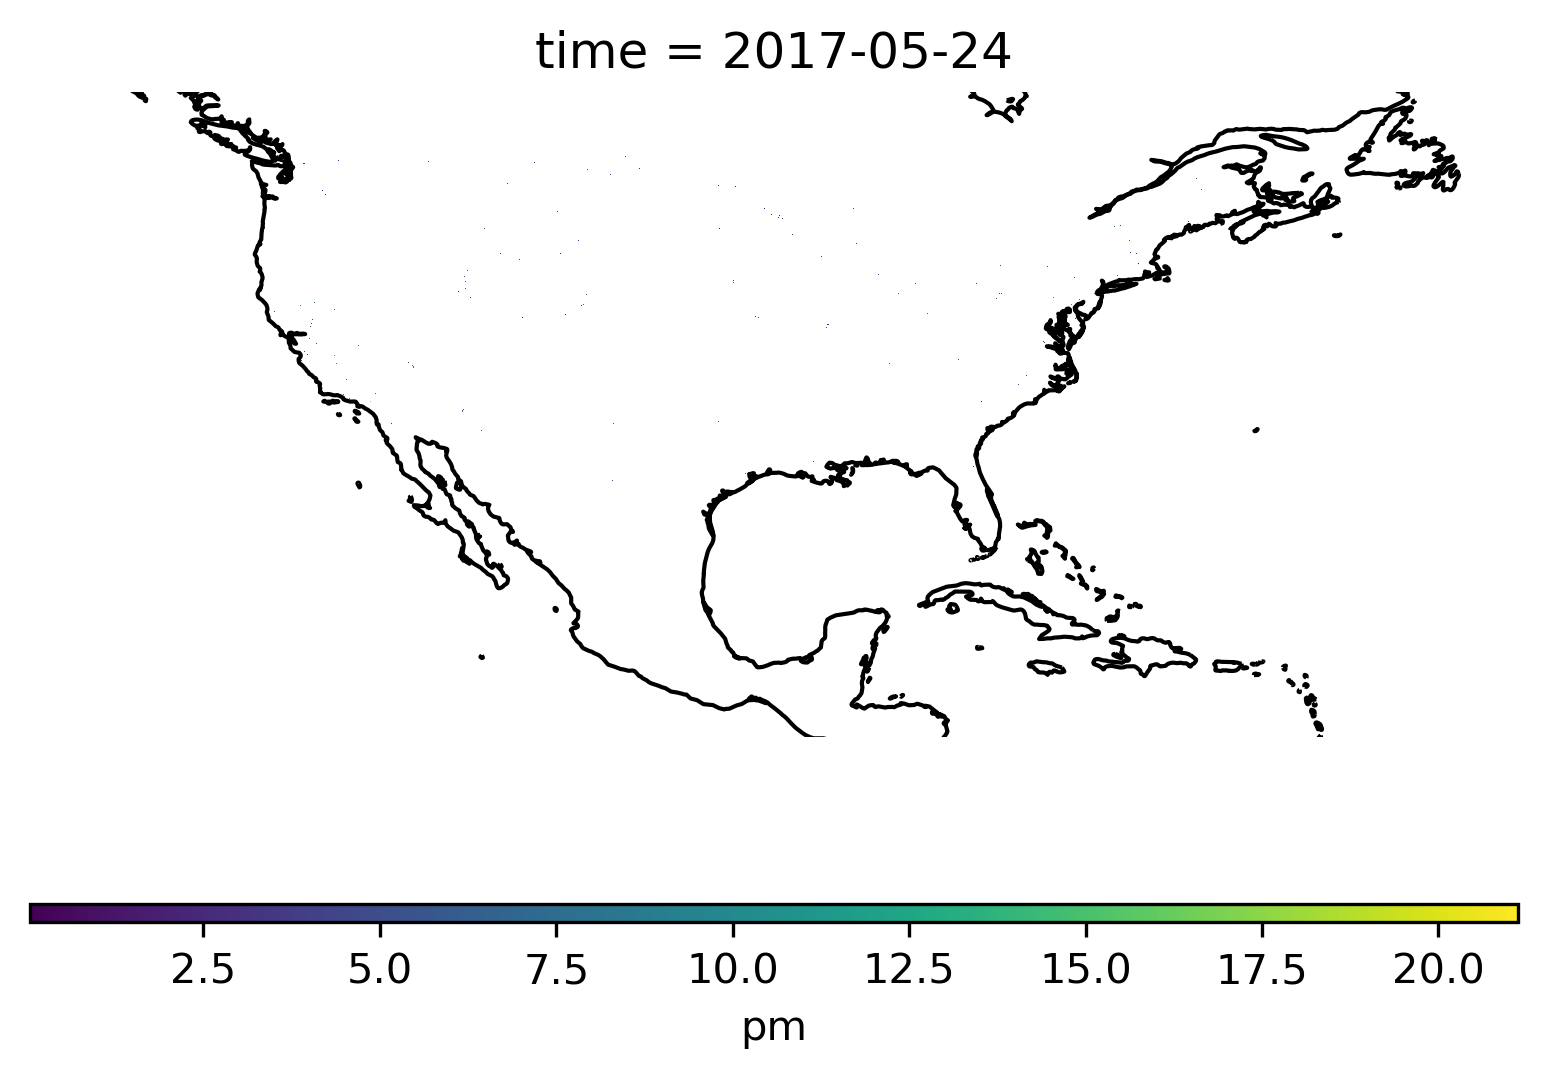

In [27]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=-75)), dpi=300)

ds.pm.plot(ax=ax, transform=proj, add_colorbar=True, cmap='viridis', cbar_kwargs=dict(orientation='horizontal', aspect=80))

ax.coastlines()
ax.spines[:].set_visible(False)